In [1]:
import os
os.chdir("/content/drive/MyDrive/DataScience/PROJECT/2022_Time_Series/time_series")

In [2]:
import pickle
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta, time

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from tqdm.auto import tqdm
from typing import Optional, Tuple

In [4]:
with open('data/pv_imputation.pickle', 'rb') as f:
    pv = pickle.load(f)

In [5]:
pv['x_time'] = [int(i.split(' ')[1]) for i in pv['time']]

# scaling

In [6]:
from sklearn.preprocessing import MinMaxScaler

In [7]:
power_scaler = MinMaxScaler()
power_scaler.fit(pv[['power']])
pv['power_scale'] = power_scaler.transform(pv[['power']])

In [8]:
x_features = ['alt', 'azi', 'rad', 'temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wspd', 'pres', 'x_time']

x_scaler = MinMaxScaler()
x_scaler.fit(pv[x_features])
pv[x_features] = x_scaler.transform(pv[x_features])

In [9]:
tz = timezone(timedelta(hours=-6))
pv_train = pv.loc[:datetime(2006,11,30,23,tzinfo=tz)]
pv_val = pv.loc[datetime(2006,11,30,18,tzinfo=tz):datetime(2006,12,20,23,tzinfo=tz)]
pv_test = pv.loc[datetime(2006,12,20,18,tzinfo=tz):datetime(2006,12,31,23,tzinfo=tz)]

pv_val_criterion = pv_val.loc[datetime(2006,12,1,00,tzinfo=tz):]
pv_test_criterion = pv_test.loc[datetime(2006,12,21,00,tzinfo=tz):]

# data loader

In [10]:
from torch.utils.data import DataLoader, Dataset

In [11]:
class windowDataset(Dataset):
    def __init__(self, y, input_window, output_window, num_feature, data_comp, stride=1):
        #총 데이터의 개수
        L = y.shape[0]
        # seq_len
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output : shape = (window 크기, sample 개수)
        X = np.zeros([input_window, num_samples, num_feature])
        Y = np.zeros([output_window, num_samples, num_feature])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i,:] = y[start_x:end_x]
            # print(X.shape)

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]
            # print(Y.shape)

        X = X.reshape(X.shape[0], X.shape[1], num_feature).transpose((1,0,2)) # (seq_len, input_window, feature)
        Y = Y.reshape(Y.shape[0], Y.shape[1], num_feature).transpose((1,0,2)) # (seq_len, output_window, 1=power)

        if data_comp==1:
            # Y = Y[:,:,0][:,:,None]
            print(Y.shape)

        if data_comp==2:
            X = Y[:,:,1:].copy()
            Y = Y[:,:,0][:,:,None]
            print(X.shape)
            print(Y.shape)
        
        self.x = X
        self.y = Y
        self.len = len(X)

    def __getitem__(self, i):
        return self.x[i], self.y[i]

    def __len__(self):
        return self.len

# model

In [12]:
"""
multihead attention layer 에서 attention energy 값 저장하도록 class 수정
need_weights=True 로 설정
"""

def attn_forward(self, query: Tensor, key: Tensor, value: Tensor, key_padding_mask: Optional[Tensor] = None,
            need_weights: bool = True, attn_mask: Optional[torch.Tensor] = None,
            average_attn_weights: bool = True) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
    is_batched = query.dim() == 3
    if self.batch_first and is_batched:
        query, key, value = [x.transpose(1, 0) for x in (query, key, value)]

    if not self._qkv_same_embed_dim:
        attn_output, attn_output_weights = F.multi_head_attention_forward(
            query, key, value, self.embed_dim, self.num_heads,
            self.in_proj_weight, self.in_proj_bias,
            self.bias_k, self.bias_v, self.add_zero_attn,
            self.dropout, self.out_proj.weight, self.out_proj.bias,
            training=self.training,
            key_padding_mask=key_padding_mask, need_weights=True,
            attn_mask=attn_mask, use_separate_proj_weight=True,
            q_proj_weight=self.q_proj_weight, k_proj_weight=self.k_proj_weight,
            v_proj_weight=self.v_proj_weight, average_attn_weights=average_attn_weights)
    else:
        attn_output, attn_output_weights = F.multi_head_attention_forward(
            query, key, value, self.embed_dim, self.num_heads,
            self.in_proj_weight, self.in_proj_bias,
            self.bias_k, self.bias_v, self.add_zero_attn,
            self.dropout, self.out_proj.weight, self.out_proj.bias,
            training=self.training,
            key_padding_mask=key_padding_mask, need_weights=True,
            attn_mask=attn_mask, average_attn_weights=average_attn_weights)
    
    # property 추가
    self.attn = attn_output_weights

    if self.batch_first and is_batched:
        return attn_output.transpose(1, 0), attn_output_weights
    else:
        return attn_output, attn_output_weights

In [13]:
def pos_encoding(dim, max_len, device='cuda'):
    pe = torch.Tensor(max_len, dim)
    pos = torch.arange(0, max_len, 1.0).unsqueeze(1)
    k = torch.exp(-np.log(10000)*torch.arange(0, dim, 2.0)/dim)
    if dim%2==0:
        pe[:,0::2] = torch.sin(pos*k)
        pe[:,1::2] = torch.cos(pos*k)
    else:
        pe[:,0::2] = torch.sin(pos*k)
        pe[:,1::2] = torch.cos(pos*k[:(dim//2)])
    return pe.to(device)

In [14]:
class transformer(nn.Module):
    def __init__(self, d_model, nhead, num_encoder_layers=1, num_decoder_layers=1, dim_feedforward=128): 
        super(transformer, self).__init__() 
        self.d_model = d_model
        self.nhead = nhead
        self.num_encoder_layers = num_encoder_layers
        self.num_decoder_layers = num_decoder_layers
        self.dim_feedforward = dim_feedforward

        # batch_first=True 인 경우 (batch, input_window, feature) 에 맞춰서 input
        self.transformer = nn.Transformer(d_model=self.d_model, 
                                          nhead=self.nhead,
                                          num_encoder_layers=self.num_encoder_layers,
                                          num_decoder_layers=self.num_decoder_layers,
                                          dim_feedforward=self.dim_feedforward,
                                          batch_first=True) 
        self.linear = nn.Linear(self.d_model, 1)

    def forward(self, src, tgt, tgt_mask=None):
        src = src + pos_encoding(self.d_model, iw).to(device).float()
        tgt = tgt + pos_encoding(self.d_model, ow).to(device).float()
        # src = self.pos_encoder(src)
        # tgt = self.pos_decoder(tgt)

        hidden = self.transformer(src, tgt, tgt_mask=tgt_mask)
        output = self.linear(hidden)
        return output, hidden

# train

In [15]:
# teacher forcing = 1
def train(model, train_loader, tgt_mask, optimizer, criterion1, criterion2, gradient_clipping=None, device='cuda'):
    model.train()
    total_loss = 0.0
    attention_list = []

    for x, y in train_loader:
        optimizer.zero_grad()
        y_in = torch.cat([x[:,-1,:].unsqueeze(1), y[:,:-1,:]], dim=1)

        x = x.to(device).float()
        y = y.to(device).float()
        y_in = y_in.to(device).float()
        
        output, hidden = model(x, y_in, tgt_mask=tgt_mask)
        attention_list.append(list(model.transformer.decoder.layers[0].multihead_attn.attn.detach().cpu().numpy()))

        # print(f"x shape: {x.shape}")
        # print(f"y shape: {y.shape}")
        # print(f"y_in shape: {y_in.shape}")
        # print(f"pred shape: {output.shape}")
        # print(f"final y shape: {y[:,:,0].shape}")
        # print(f"final pred shape: {output[:,:,0].shape}")

        # print(f"loss1 output: {output[:,:,0].shape}")
        # print(f"loss1 y: {y[:,:,0].shape}")
        # print(f"loss2 output: {hidden.shape}")
        # print(f"loss2 y: {y.shape}")
        loss1 = criterion1(output[:,-stride:,0], y[:,-stride:,0])
        loss2 = criterion2(hidden, y)
        loss = loss1+loss2
        loss.backward()
        if gradient_clipping:
            torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
        optimizer.step()
        total_loss += loss.cpu().item()
    train_loss = total_loss/len(train_loader)

    return output.detach().cpu().numpy(), y.detach().cpu().numpy(), np.array(sum(attention_list,[])), train_loss

In [16]:
def predict(model, test_loader, max_len, criterion, device='cuda', file_name=None):
    model.eval()

    total_loss = 0.0
    outputs = []
    ys = []
    attention_list = []

    for t, (x, y_out) in enumerate(test_loader):
        x = x.to(device).float()
        y_out = y_out.to(device).float()

        with torch.no_grad():
            # enc_src = model.transformer.encoder(x)
            enc_src = x + pos_encoding(x.shape[2], x.shape[1]).to(device).float()
            enc_src = model.transformer.encoder(enc_src)

        dec_src = x[:,-1,:].unsqueeze(1)
        attention = torch.Tensor().to(device)
        output = torch.Tensor().to(device)

        for _ in range(max_len):
            target_mask = model.transformer.generate_square_subsequent_mask(dec_src.shape[1]).to(device)

            with torch.no_grad():
                dec_src2 = dec_src + pos_encoding(dec_src.shape[2], dec_src.shape[1]).to(device).float()
                hidden = model.transformer.decoder(dec_src2, enc_src, target_mask)
                out = model.linear(hidden)
            attn_ = model.transformer.decoder.layers[0].multihead_attn.attn[:,-1,:].unsqueeze(1)

            dec_src = torch.cat([dec_src, hidden[:,-1,:].unsqueeze(1)], dim=1)
            output = torch.cat([output, out[:,-1,:].unsqueeze(1)], dim=1)
            attention = torch.cat([attention, attn_], dim=1)

        attention_list.append(list(attention.detach().cpu().numpy()))
        outputs.append(list(output.detach().cpu().numpy()))
        ys.append(list(y_out.detach().cpu().numpy()))

        loss = criterion(output[:,-stride:,0], y_out[:,-stride:,0])
        total_loss += loss.cpu().item()

    test_loss = total_loss/len(test_loader)
    # print(f"test loss: {(total_loss/len(test_loader)):.5f}")

    return np.array(sum(outputs,[])), np.array(sum(ys,[])), np.array(sum(attention_list, [])), test_loss

In [17]:
iw = 6
ow = 6
stride = 6
num_feature = len(x_features)+1

train_dataset = windowDataset(pv_train[['power_scale']+x_features], 
                              input_window=iw, output_window=ow, num_feature=num_feature, data_comp=1, stride=stride)
valid_dataset = windowDataset(pv_val[['power_scale']+x_features], 
                             input_window=iw, output_window=ow, num_feature=num_feature, data_comp=1, stride=stride)
test_dataset = windowDataset(pv_test[['power_scale']+x_features], 
                             input_window=iw, output_window=ow, num_feature=num_feature, data_comp=1, stride=stride)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

(1335, 6, 12)
(80, 6, 12)
(44, 6, 12)


In [18]:
a = next(iter(train_loader))
print(a[0].shape)
print(a[1].shape)

torch.Size([64, 6, 12])
torch.Size([64, 6, 12])


In [34]:
param_config = {
    "learning_rate": 0.001,
    "epochs": 1000,
    "d_model": len(x_features)+1,
    "nhead": 1,
    "num_encoder_layers": 1,
    "num_decoder_layers": 1,
    "dim_feedforward": 128
}

In [35]:
device='cuda'
model = transformer(d_model=param_config["d_model"], 
                       nhead=param_config["nhead"], 
                       num_encoder_layers=param_config["num_encoder_layers"], 
                       num_decoder_layers=param_config["num_decoder_layers"], 
                       dim_feedforward=param_config["dim_feedforward"]).to(device)

optimizer = optim.Adam(model.parameters(), lr = param_config['learning_rate'])
criterion1 = nn.MSELoss()
criterion2 = nn.MSELoss()

In [36]:
# multihead attention layer 에서 수정
model.transformer.decoder.layers[0].multihead_attn.__class__._forward = attn_forward
for layer in model.transformer.decoder.layers:
    layer.multihead_attn.forward = layer.multihead_attn._forward

In [37]:
# 파라미터 수 계산
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 8,477 trainable parameters


In [38]:
# # 파라미터 초기화
# def initialize_weights(m):
#     if hasattr(m, 'weight') and m.weight.dim() > 1:
#         nn.init.xavier_uniform_(m.weight.data)

# model.apply(initialize_weights)

In [39]:
target_mask = model.transformer.generate_square_subsequent_mask(ow).to(device)

In [40]:
# wandb.watch(model, log='all', log_freq=10)

val_loss_min = 100
file_name = 'model/basic.model'

pbar = tqdm(range(param_config['epochs']))
for epoch in pbar:
    *result_train, train_loss = train(model, train_loader, target_mask, optimizer, criterion1, criterion2, gradient_clipping=3, device=device)
    *result_val, val_loss = predict(model, val_loader, ow, criterion1, device=device)
    *result_test, test_loss = predict(model, test_loader, ow, criterion1, device=device)

    if val_loss < val_loss_min:
        val_loss_min = val_loss
        torch.save(model.state_dict(), file_name)
        print(f"epoch: {epoch} / val_loss: {val_loss:.5f} / test_loss: {test_loss:.5f}")

    # wandb.log({"train_loss": train_loss, "val_loss": val_loss, "test_loss": test_loss, "val_loss_min": val_loss_min})

    pbar.set_postfix(loss=f"train_loss: {train_loss:.5f} / val_loss: {val_loss:.5f} / test_loss: {test_loss:.5f}")

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 0 / val_loss: 0.07411 / test_loss: 0.09357
epoch: 2 / val_loss: 0.07109 / test_loss: 0.04726
epoch: 3 / val_loss: 0.04677 / test_loss: 0.04617
epoch: 4 / val_loss: 0.03802 / test_loss: 0.04265
epoch: 5 / val_loss: 0.03501 / test_loss: 0.04286
epoch: 21 / val_loss: 0.03274 / test_loss: 0.02252
epoch: 23 / val_loss: 0.03046 / test_loss: 0.01993
epoch: 25 / val_loss: 0.02802 / test_loss: 0.01905
epoch: 26 / val_loss: 0.02720 / test_loss: 0.01842
epoch: 30 / val_loss: 0.02596 / test_loss: 0.01756
epoch: 35 / val_loss: 0.02120 / test_loss: 0.01519
epoch: 40 / val_loss: 0.02031 / test_loss: 0.01644
epoch: 48 / val_loss: 0.01627 / test_loss: 0.01675
epoch: 49 / val_loss: 0.01459 / test_loss: 0.01446
epoch: 72 / val_loss: 0.01439 / test_loss: 0.01685
epoch: 76 / val_loss: 0.01401 / test_loss: 0.01476
epoch: 84 / val_loss: 0.01303 / test_loss: 0.01516
epoch: 91 / val_loss: 0.01302 / test_loss: 0.01465
epoch: 106 / val_loss: 0.01301 / test_loss: 0.01588
epoch: 107 / val_loss: 0.01286 / te

# result

In [41]:
pred_val = result_val[0]
pred_val = power_scaler.inverse_transform(pred_val[:,-stride:,0].reshape(-1,1))
print(f"pred_val: {len(pred_val)}")

pred_test = result_test[0]
pred_test = power_scaler.inverse_transform(pred_test[:,-stride:,0].reshape(-1,1))
print(f"pred_test: {len(pred_test)}")

pv_val_criterion['pred'] = pred_val.reshape(-1)
pv_test_criterion['pred'] = pred_test.reshape(-1)

pred_val: 480
pred_test: 264


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

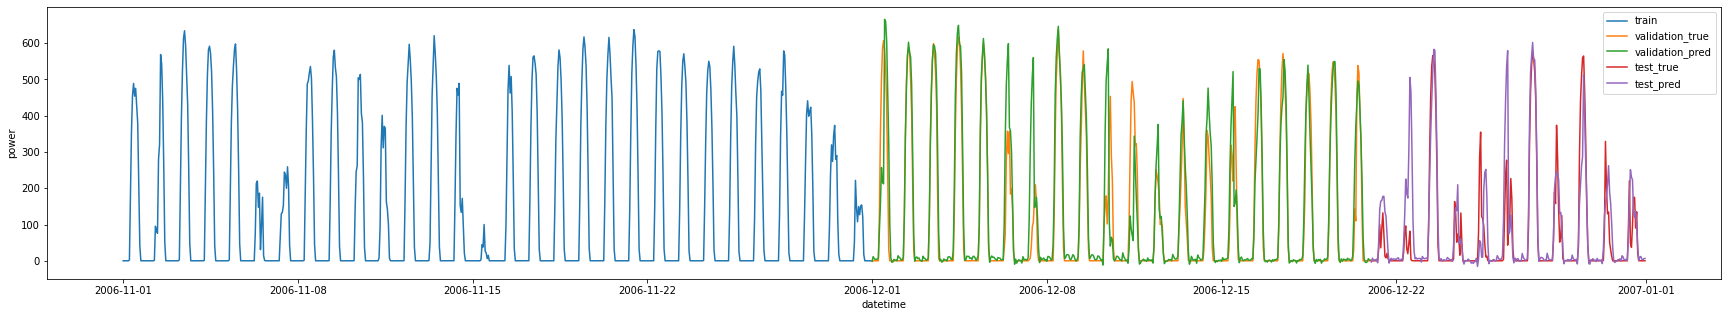

In [42]:
plt.figure(figsize=(30,5))

sns.lineplot(pv_train.loc[datetime(2006,11,1,00,tzinfo=tz):].index, pv_train.loc[datetime(2006,11,1,00,tzinfo=tz):]['power'], label='train')
sns.lineplot(pv_val_criterion.index, pv_val_criterion['power'], label='validation_true')
sns.lineplot(pv_val_criterion.index, pv_val_criterion['pred'], label='validation_pred')
sns.lineplot(pv_test_criterion.index, pv_test_criterion['power'], label='test_true')
sns.lineplot(pv_test_criterion.index, pv_test_criterion['pred'], label='test_pred')
plt.legend()

In [43]:
print(f"validation MSE: {mean_squared_error(pv_val_criterion['power'], pv_val_criterion['pred']):.5f}")
print(f"validation R2: {r2_score(pv_val_criterion['power'], pv_val_criterion['pred']):.5f}")

print(f"validation MSE: {mean_squared_error(pv_test_criterion['power'], pv_test_criterion['pred']):.5f}")
print(f"validation R2: {r2_score(pv_test_criterion['power'], pv_test_criterion['pred']):.5f}")

validation MSE: 8058.75746
validation R2: 0.77546
validation MSE: 7721.54585
validation R2: 0.59980


In [44]:
model.load_state_dict(torch.load(file_name))
*result_val, val_loss = predict(model, val_loader, ow, criterion1, device=device)
*result_test, test_loss = predict(model, test_loader, ow, criterion1, device=device)

In [45]:
pred_val = result_val[0]
pred_val = power_scaler.inverse_transform(pred_val[:,-stride:,0].reshape(-1,1))
print(f"pred_val: {len(pred_val)}")

pred_test = result_test[0]
pred_test = power_scaler.inverse_transform(pred_test[:,-stride:,0].reshape(-1,1))
print(f"pred_test: {len(pred_test)}")

pv_val_criterion['pred'] = pred_val.reshape(-1)
pv_test_criterion['pred'] = pred_test.reshape(-1)

pred_val: 480
pred_test: 264


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

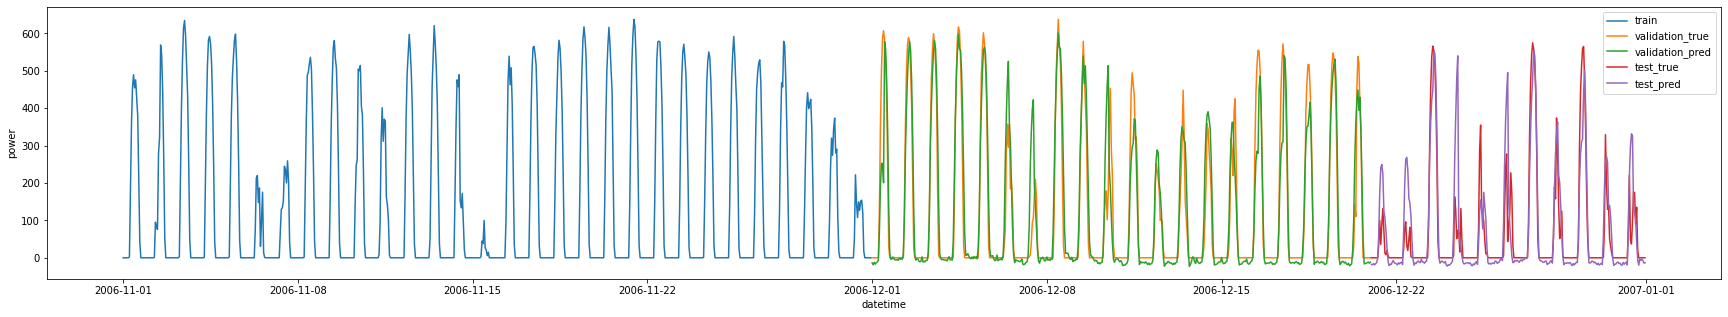

In [46]:
plt.figure(figsize=(30,5))

sns.lineplot(pv_train.loc[datetime(2006,11,1,00,tzinfo=tz):].index, pv_train.loc[datetime(2006,11,1,00,tzinfo=tz):]['power'], label='train')
sns.lineplot(pv_val_criterion.index, pv_val_criterion['power'], label='validation_true')
sns.lineplot(pv_val_criterion.index, pv_val_criterion['pred'], label='validation_pred')
sns.lineplot(pv_test_criterion.index, pv_test_criterion['power'], label='test_true')
sns.lineplot(pv_test_criterion.index, pv_test_criterion['pred'], label='test_pred')
plt.legend()

In [47]:
print(f"validation MSE: {mean_squared_error(pv_val_criterion['power'], pv_val_criterion['pred']):.5f}")
print(f"validation R2: {r2_score(pv_val_criterion['power'], pv_val_criterion['pred']):.5f}")

print(f"validation MSE: {mean_squared_error(pv_test_criterion['power'], pv_test_criterion['pred']):.5f}")
print(f"validation R2: {r2_score(pv_test_criterion['power'], pv_test_criterion['pred']):.5f}")

validation MSE: 5729.16560
validation R2: 0.84037
validation MSE: 6892.90734
validation R2: 0.64275


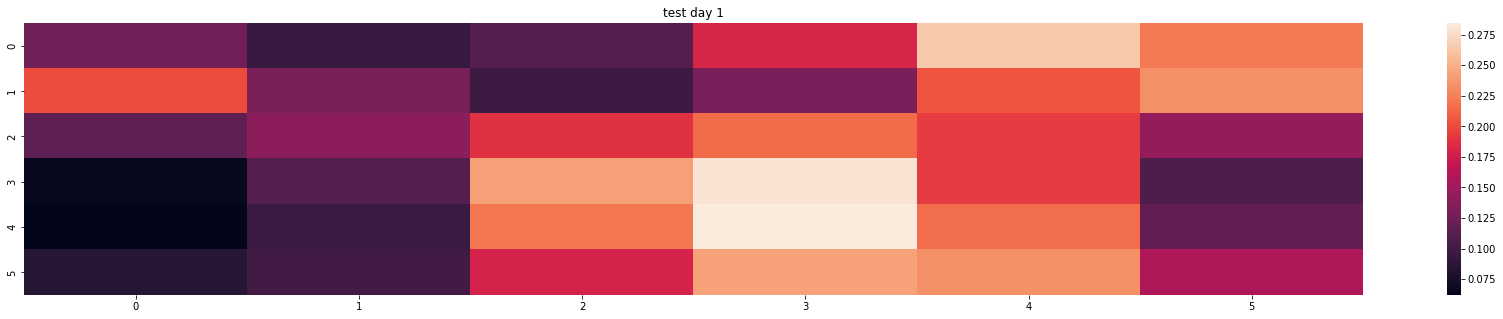

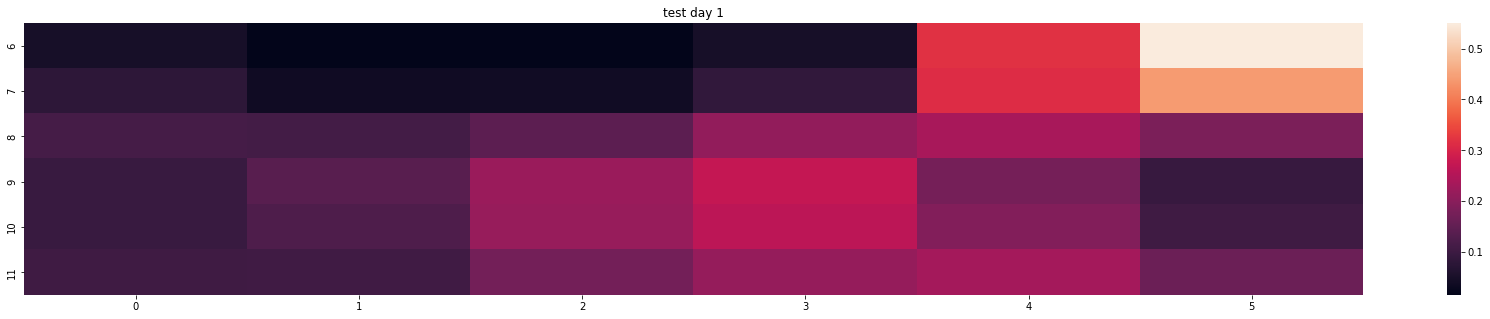

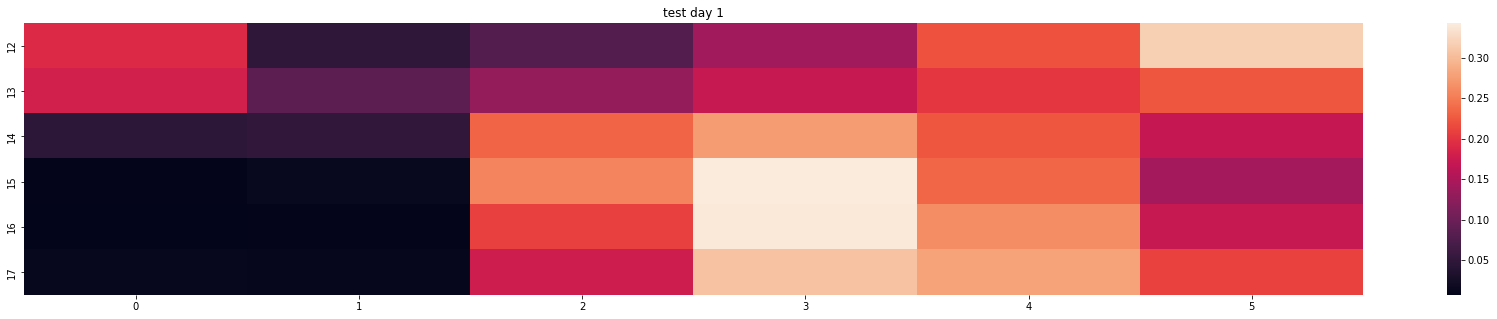

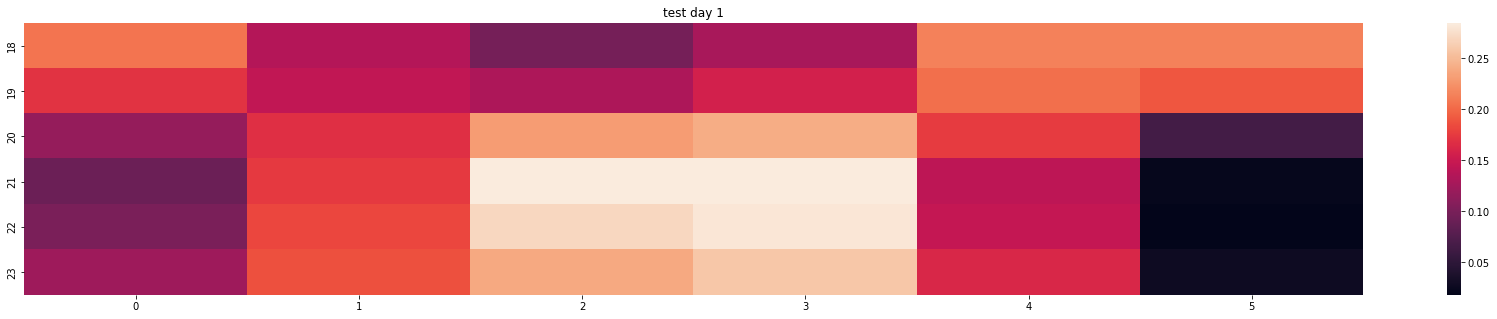

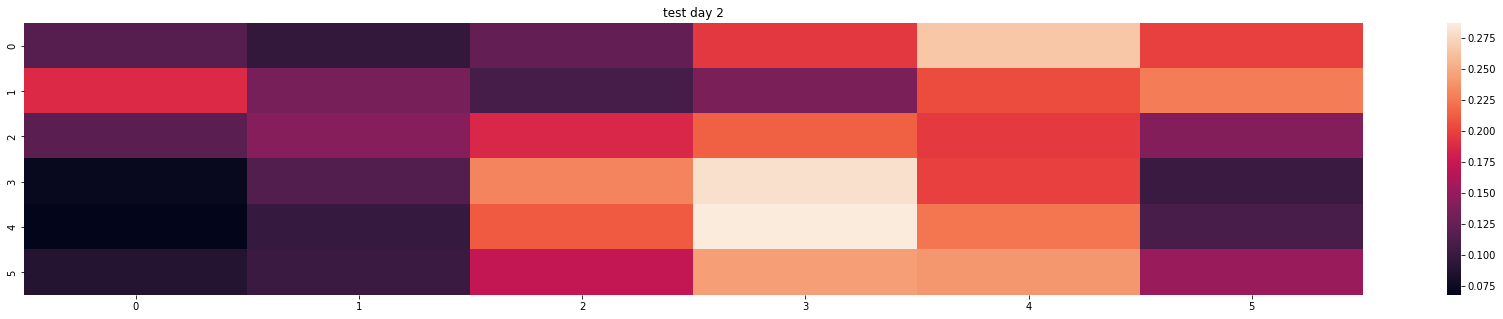

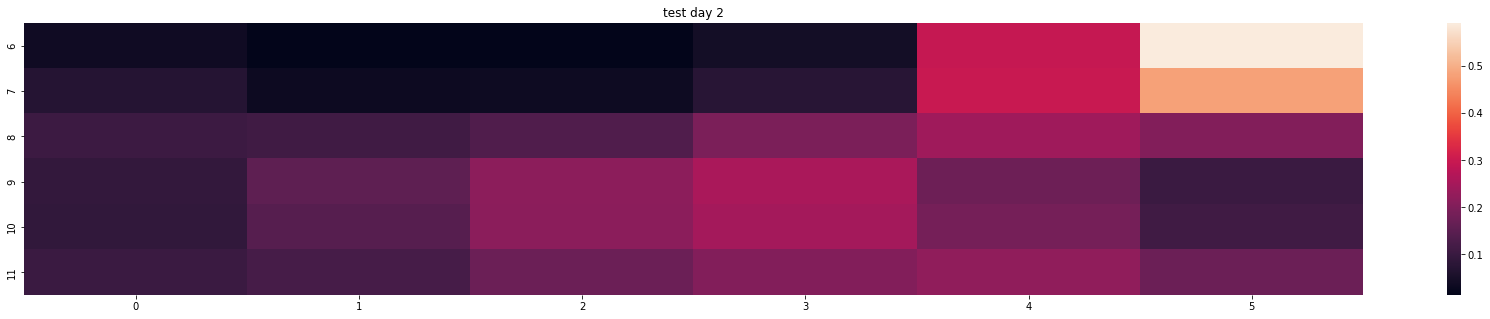

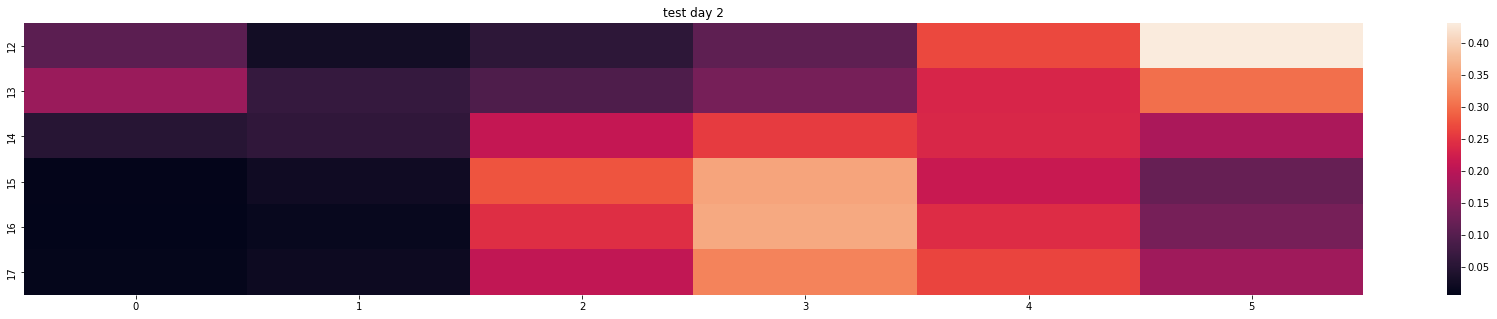

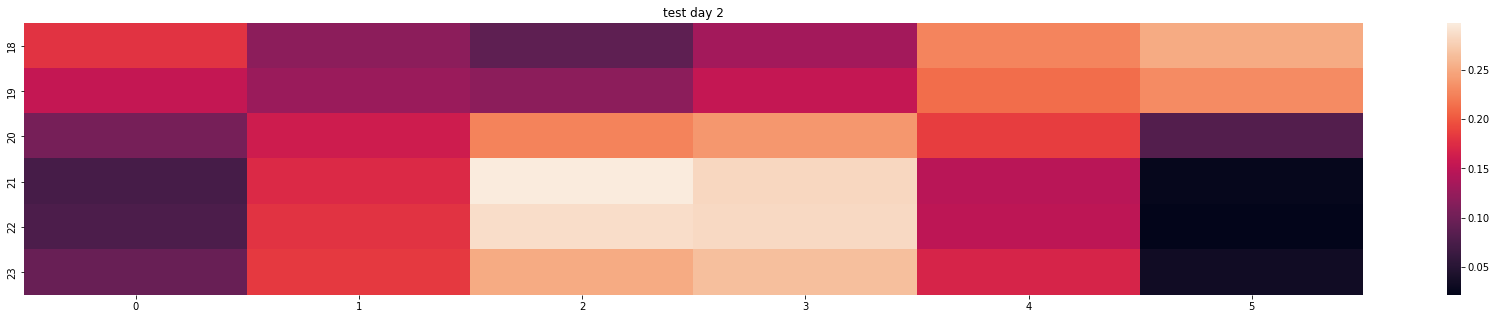

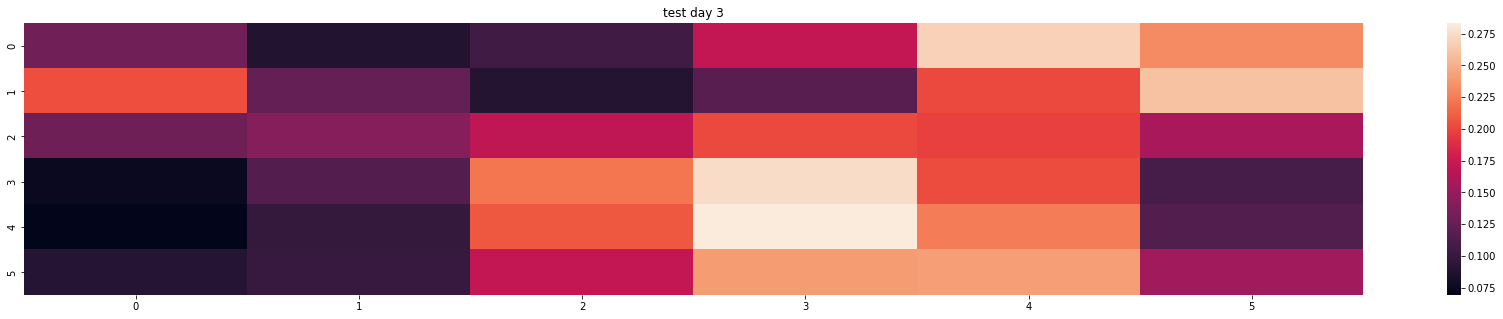

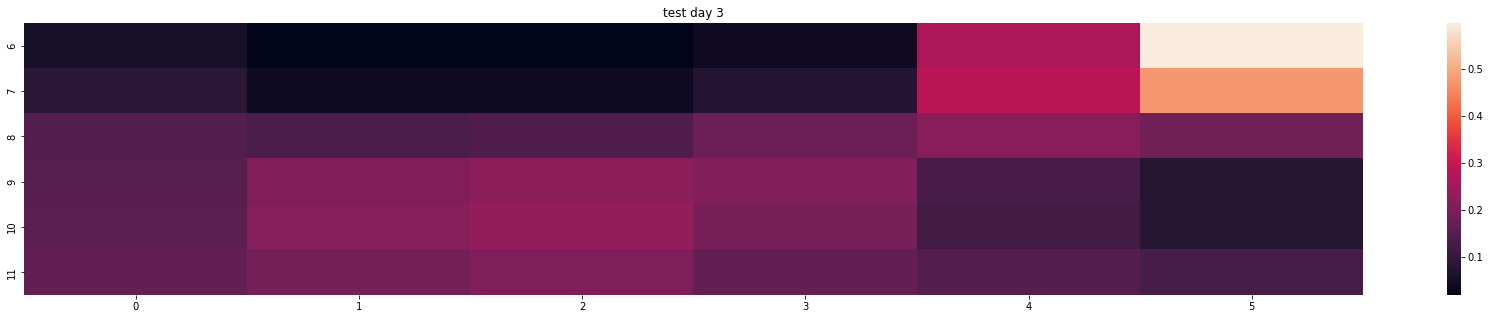

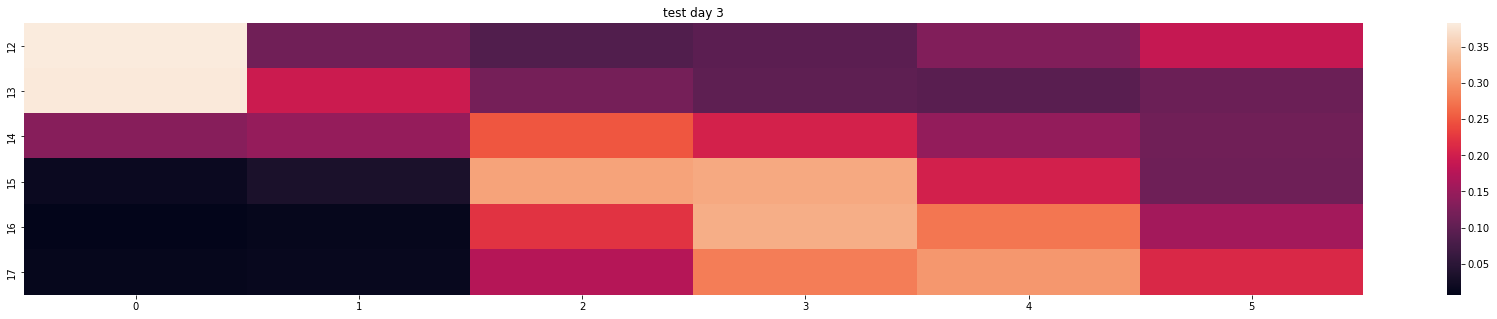

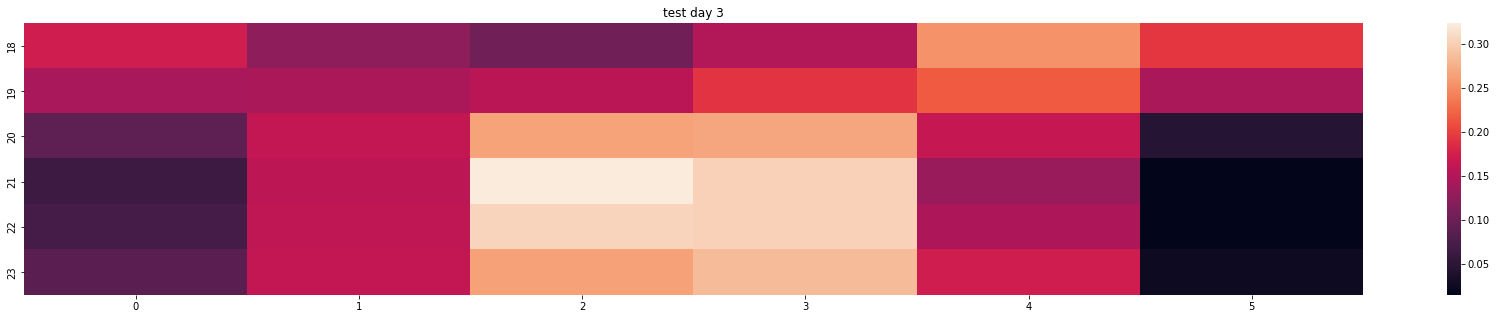

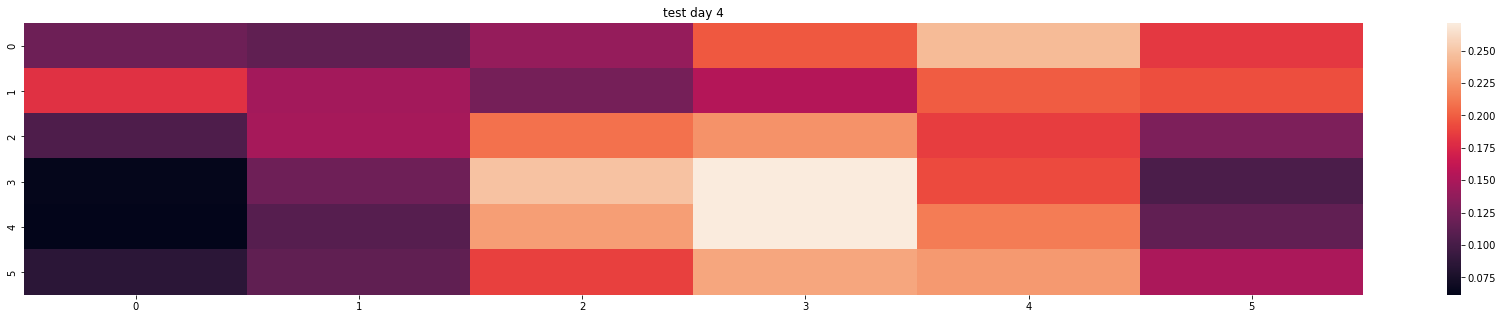

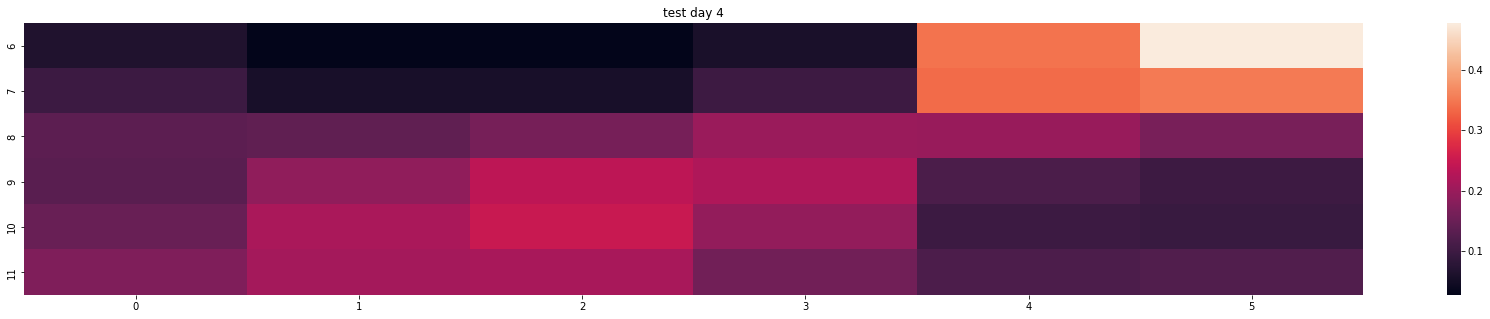

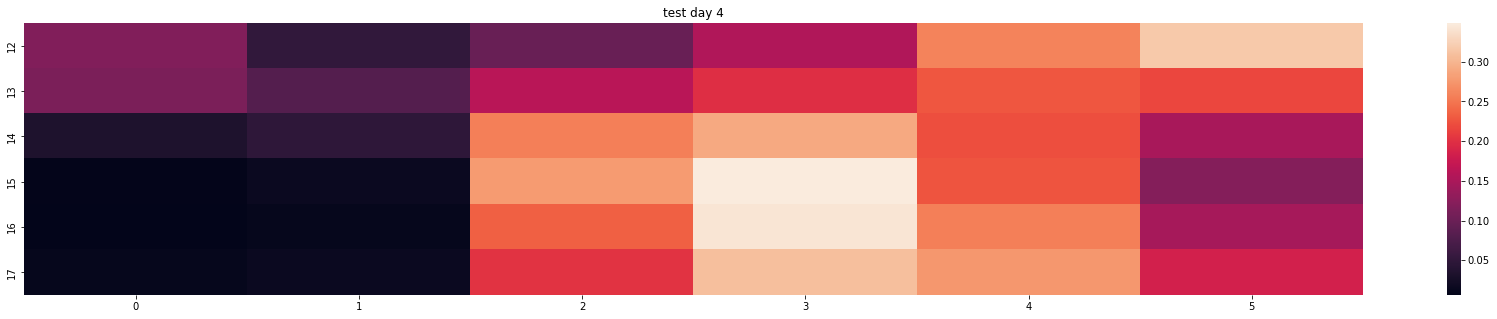

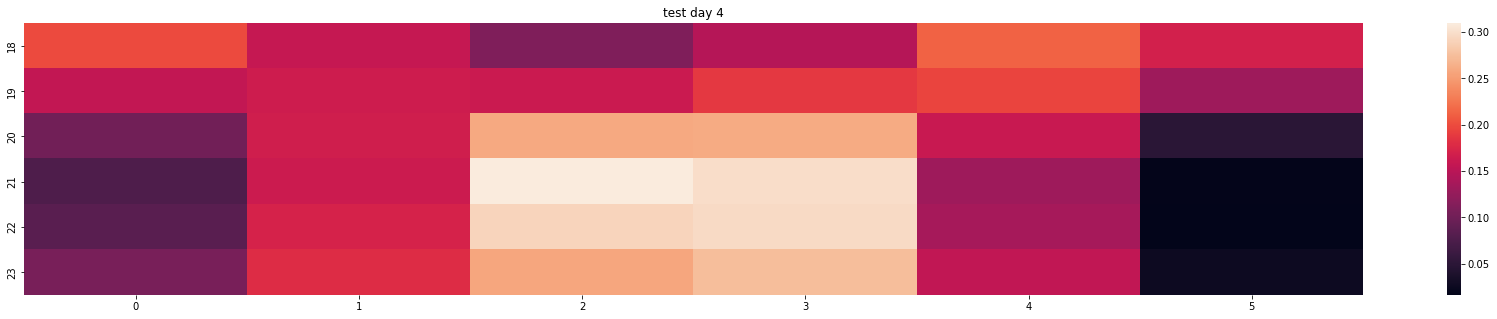

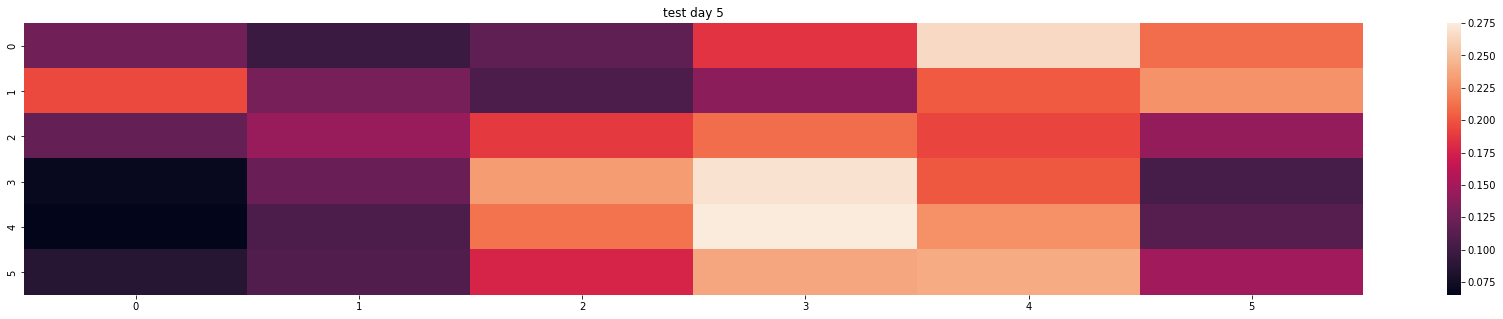

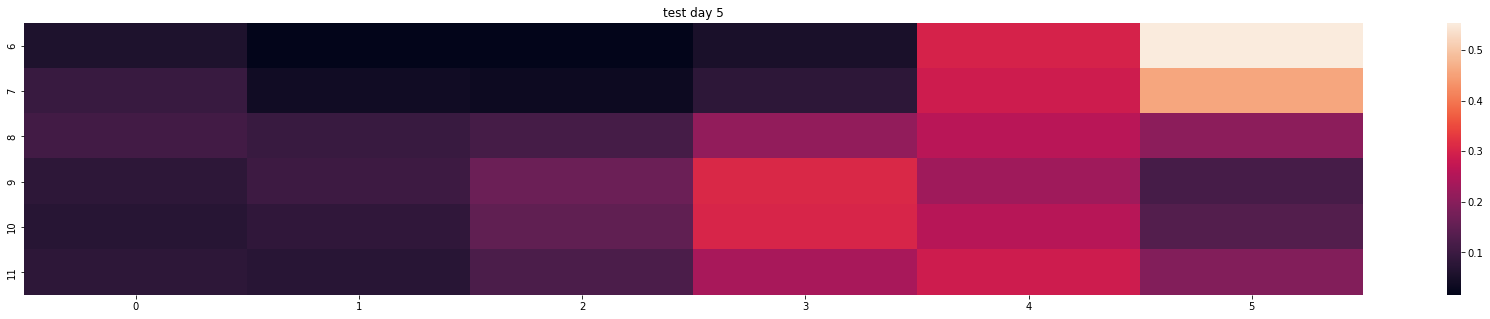

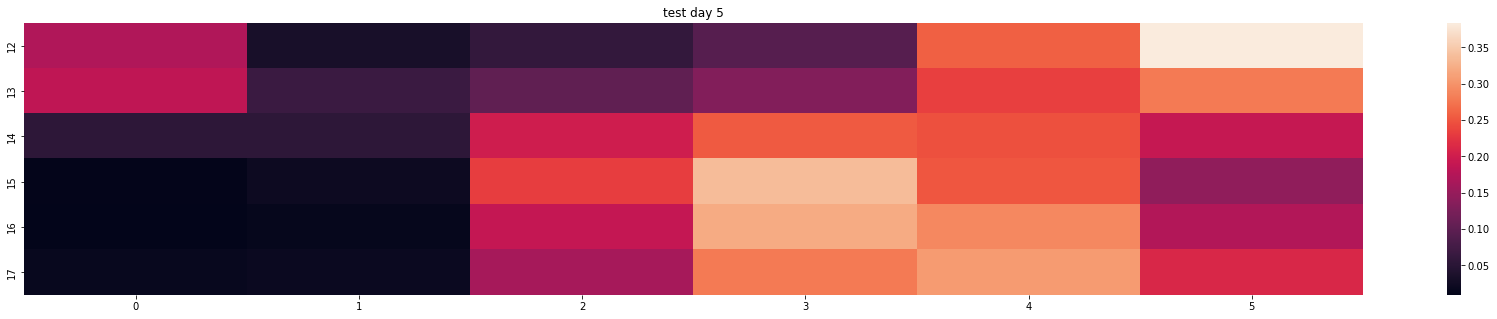

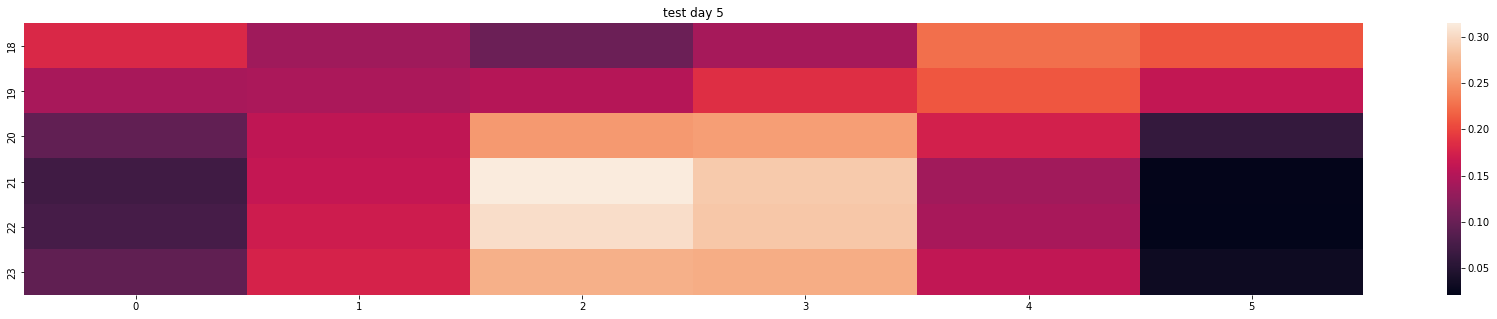

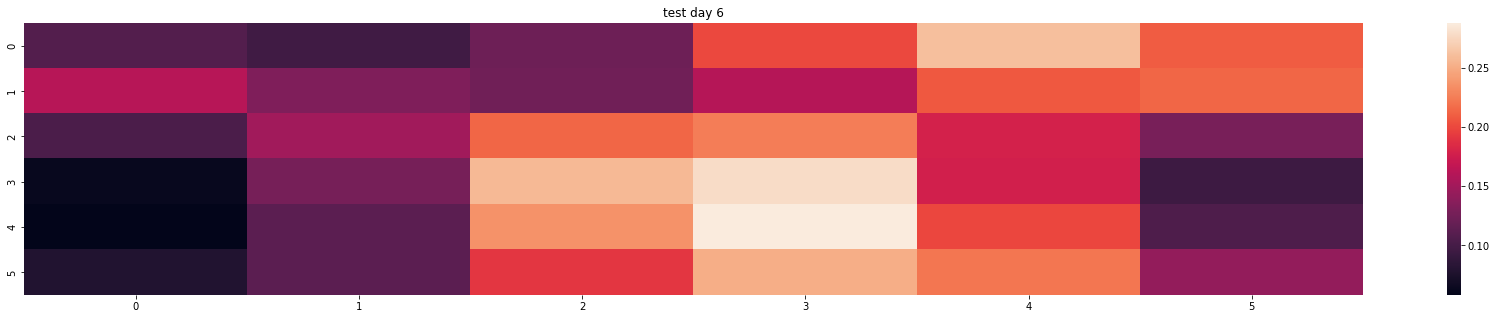

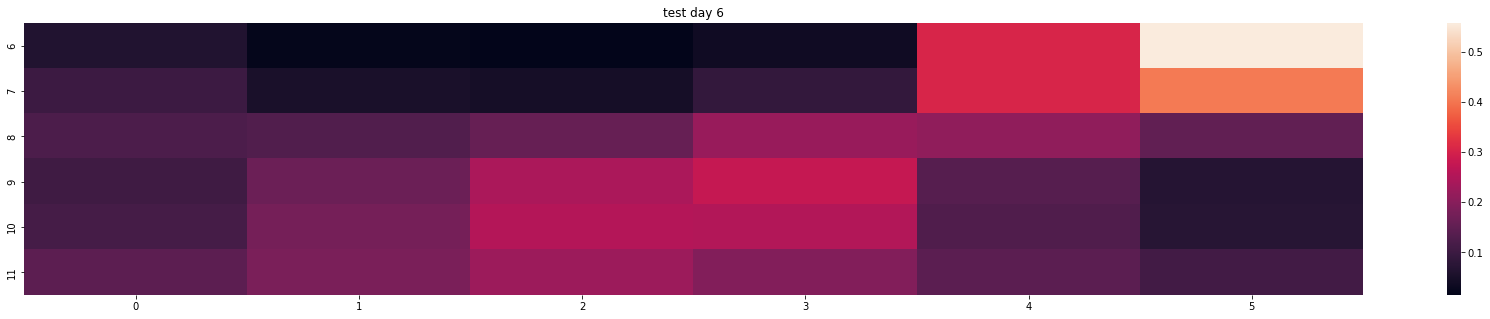

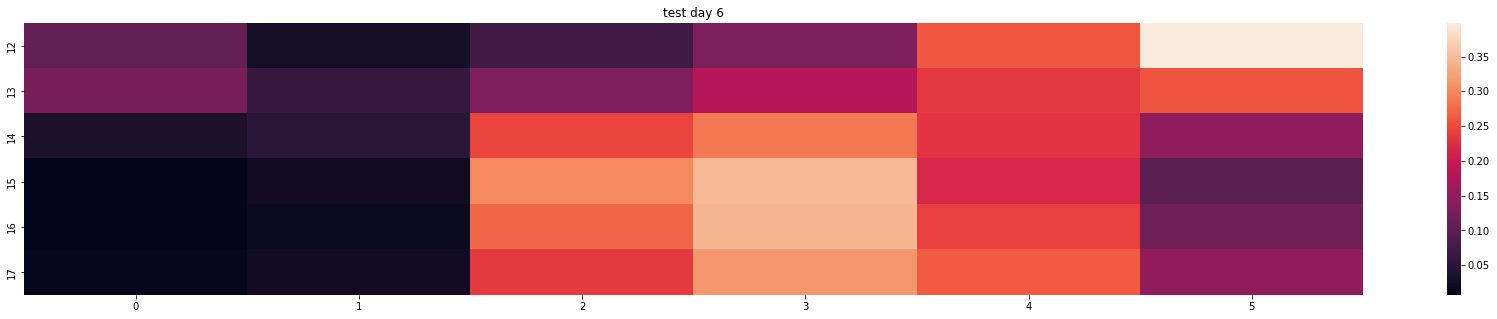

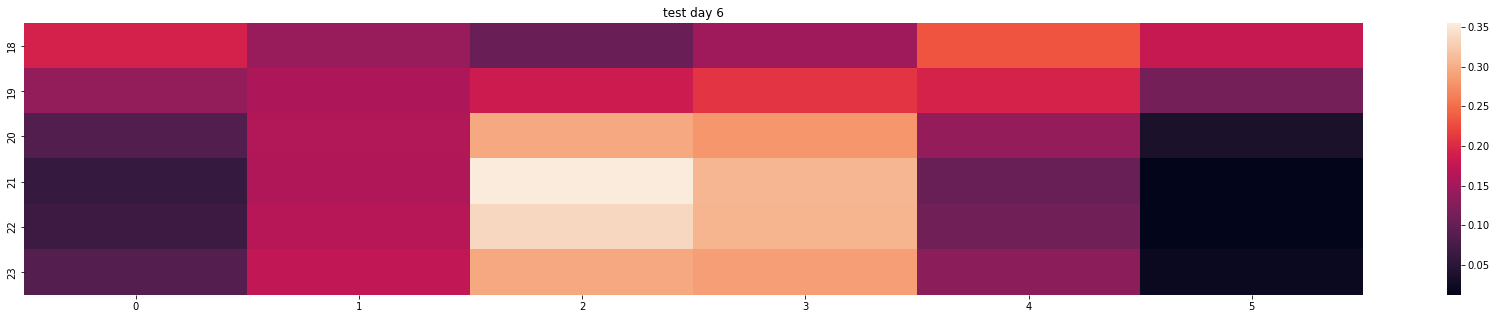

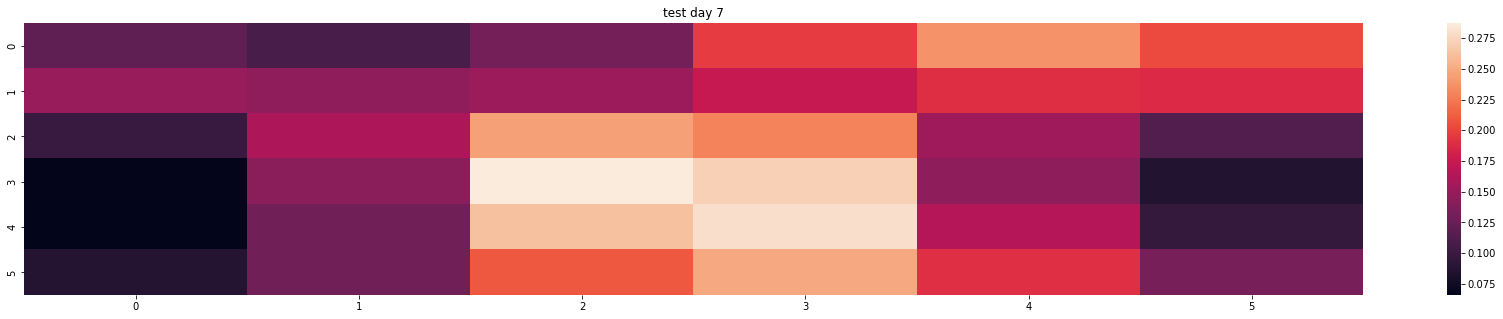

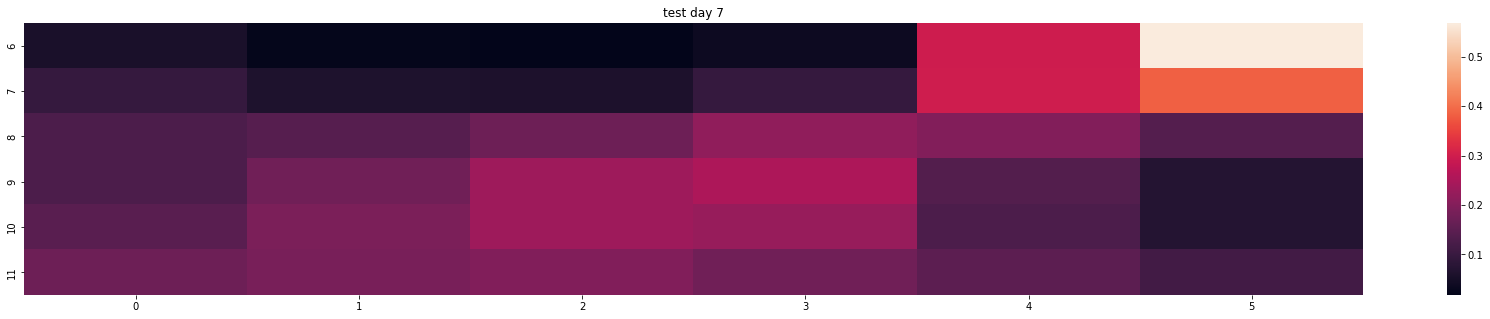

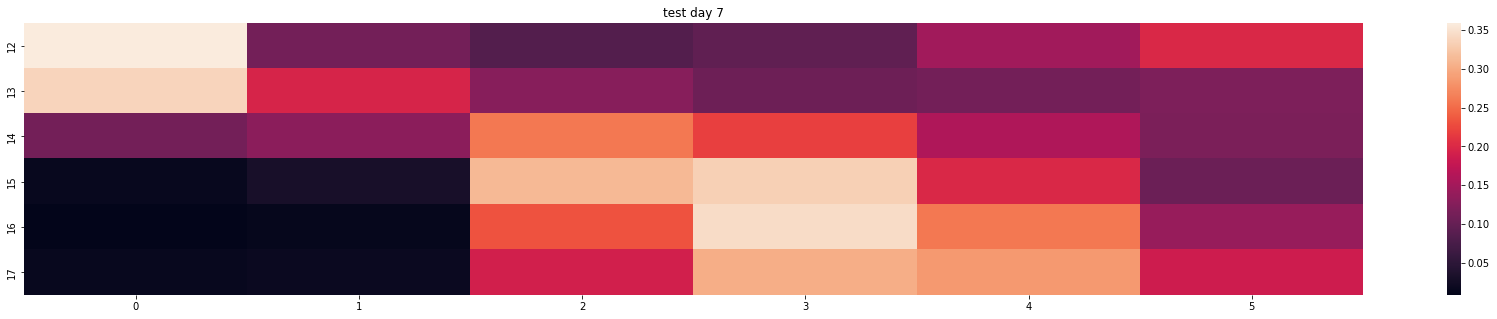

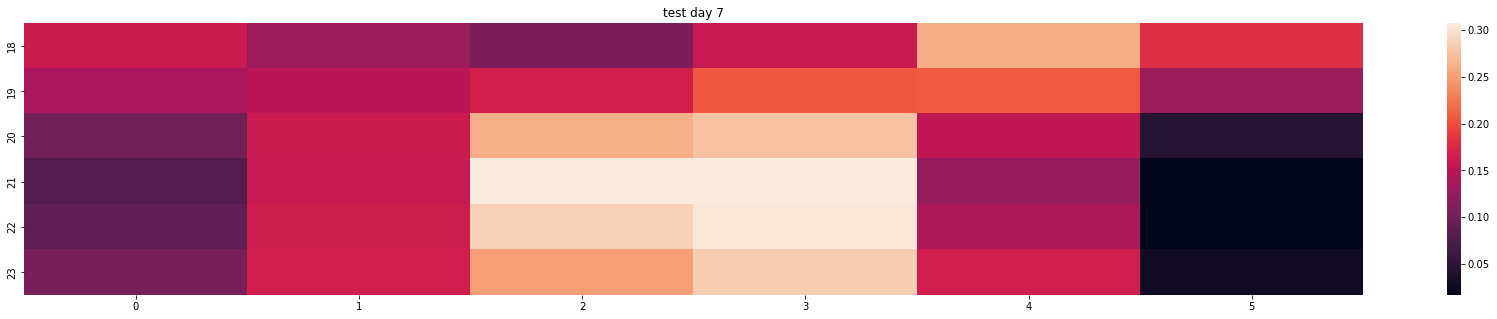

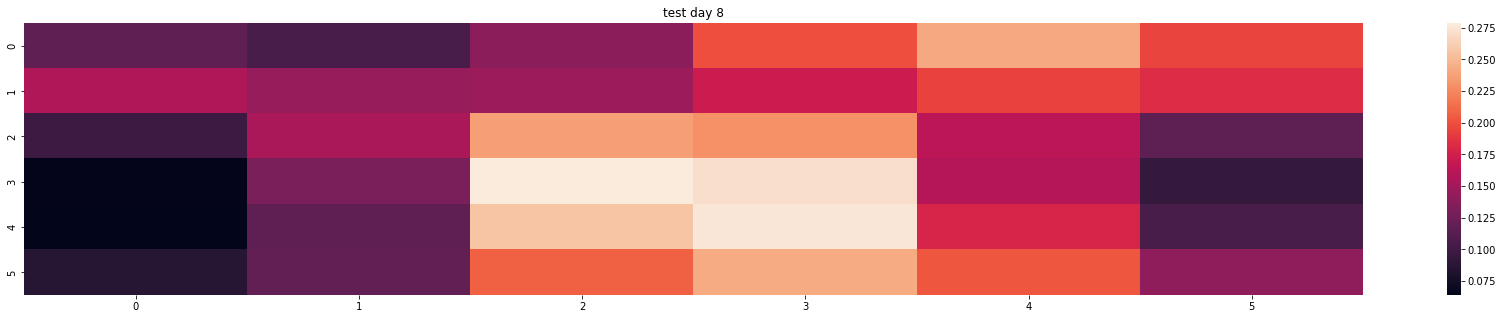

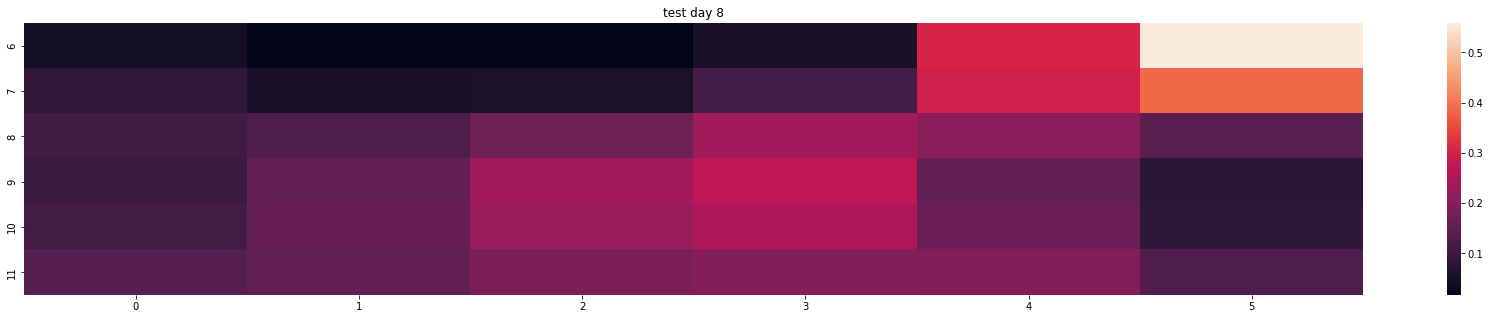

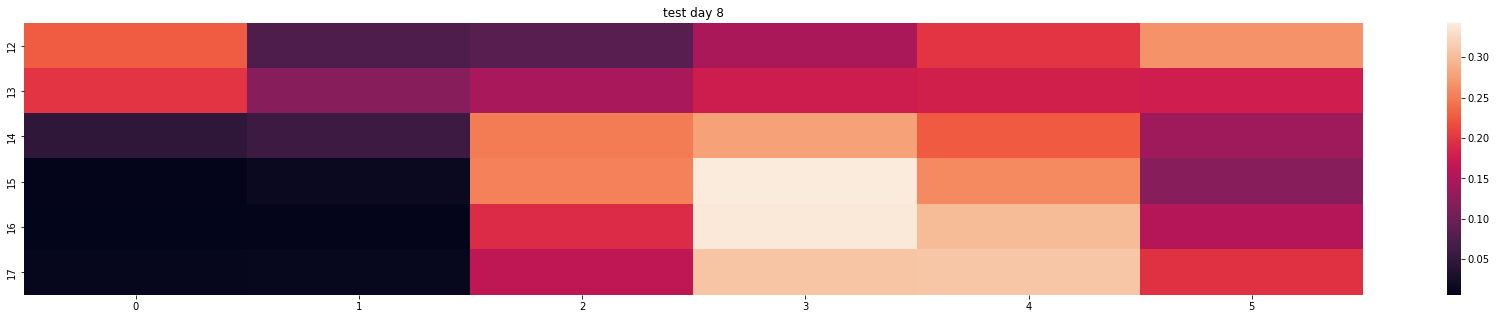

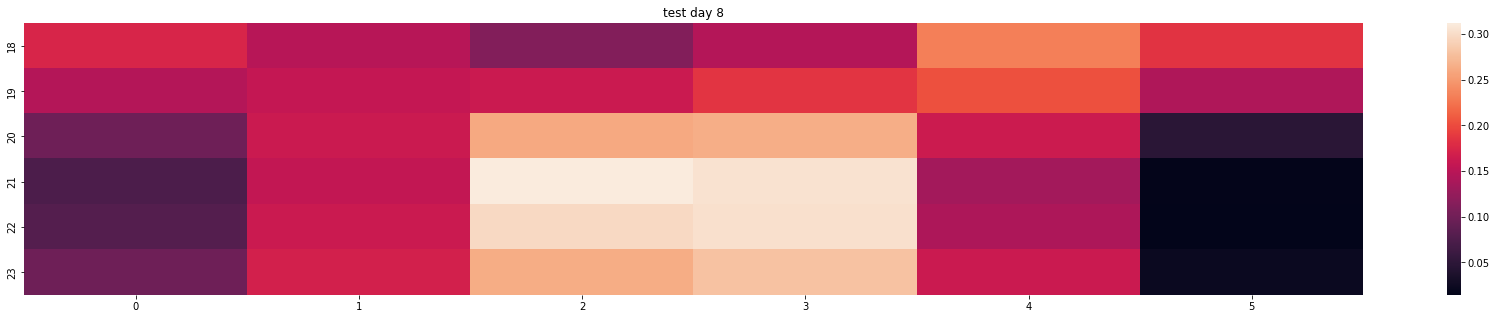

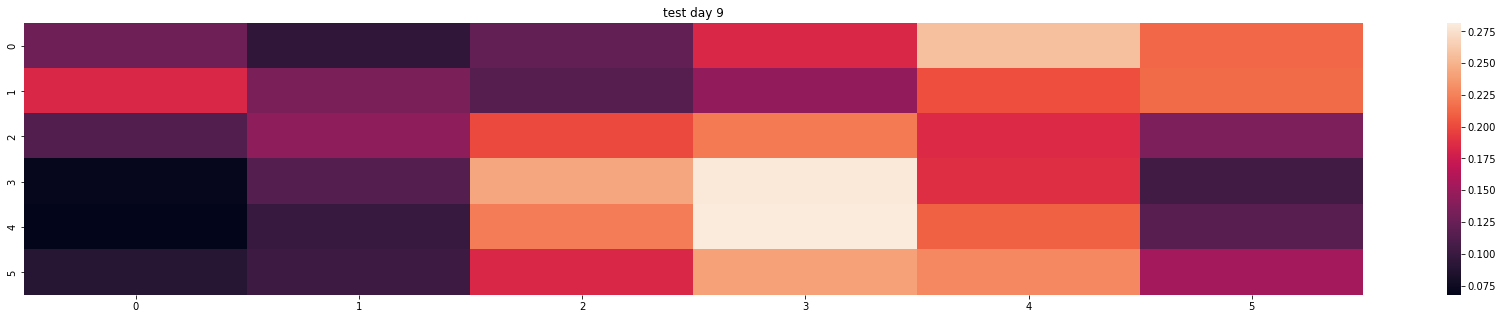

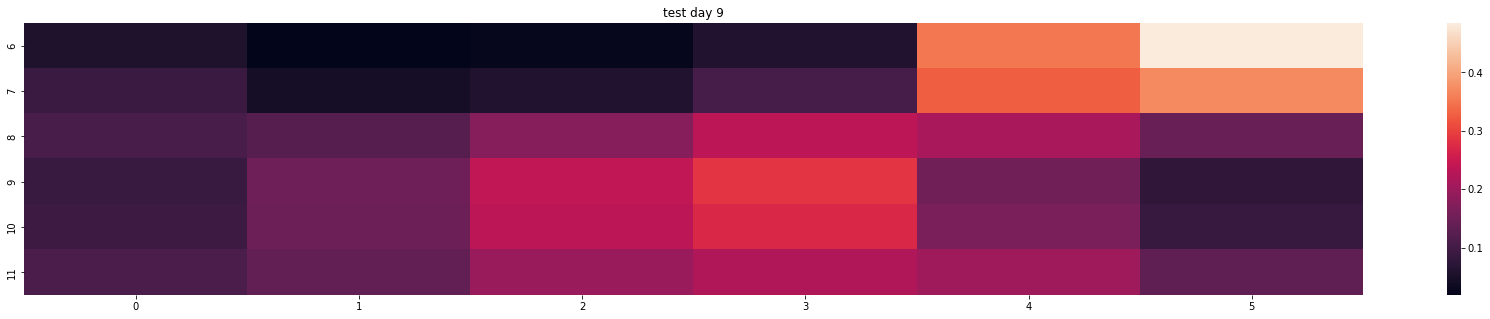

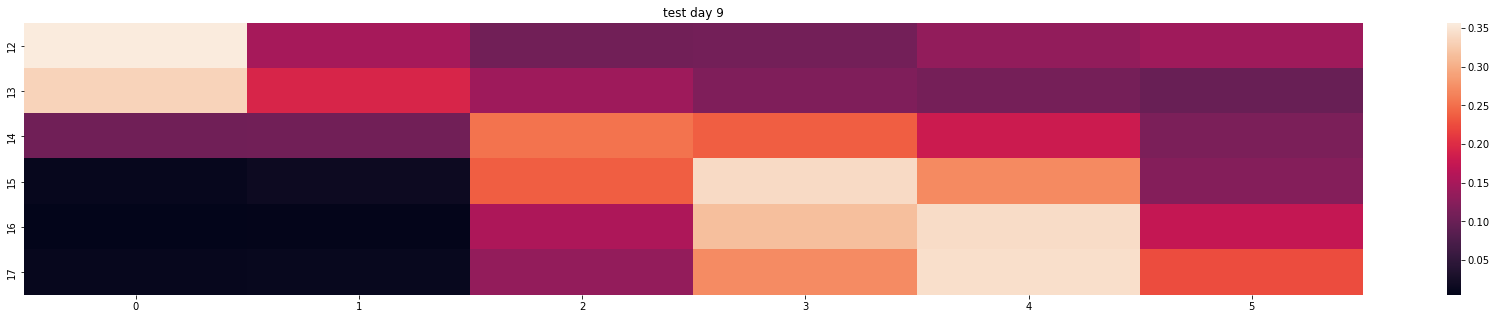

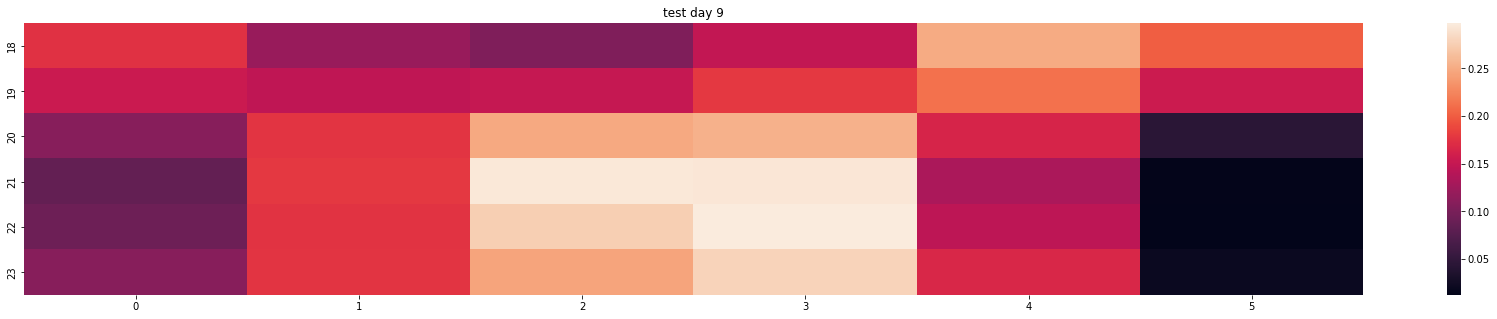

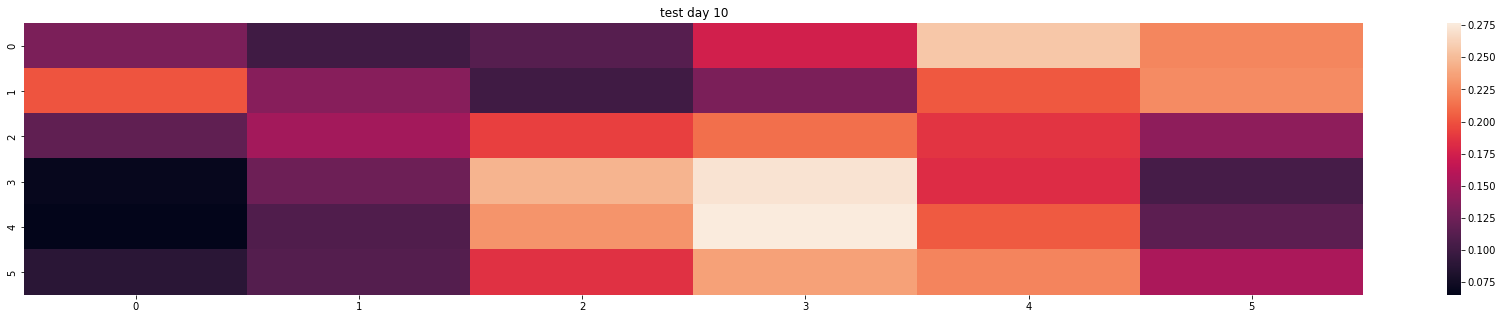

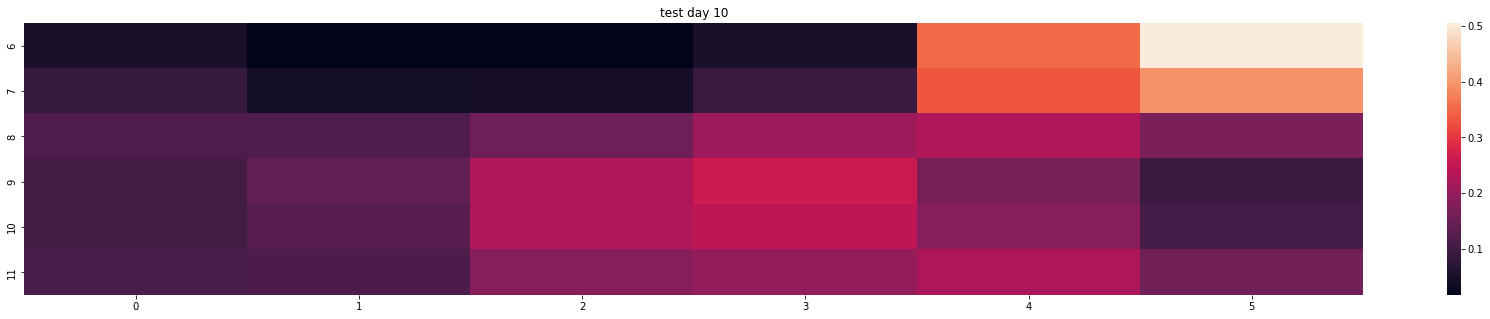

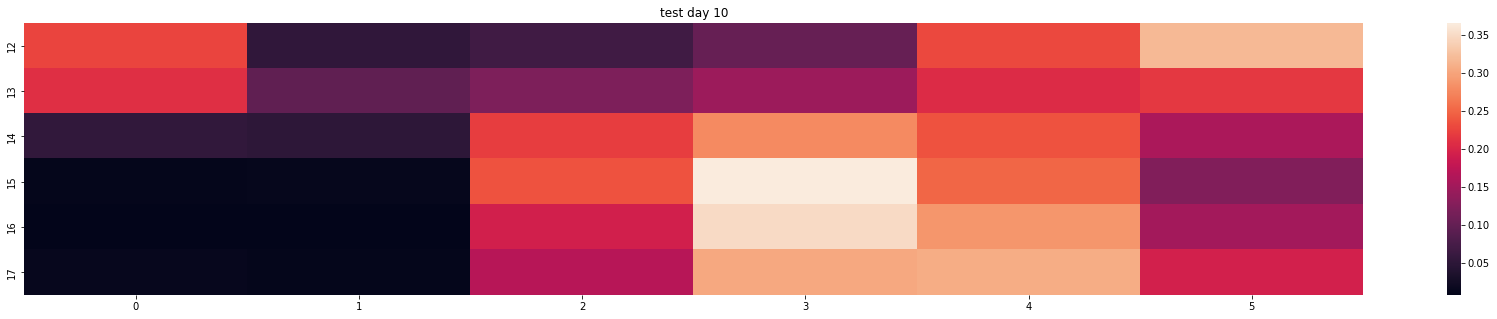

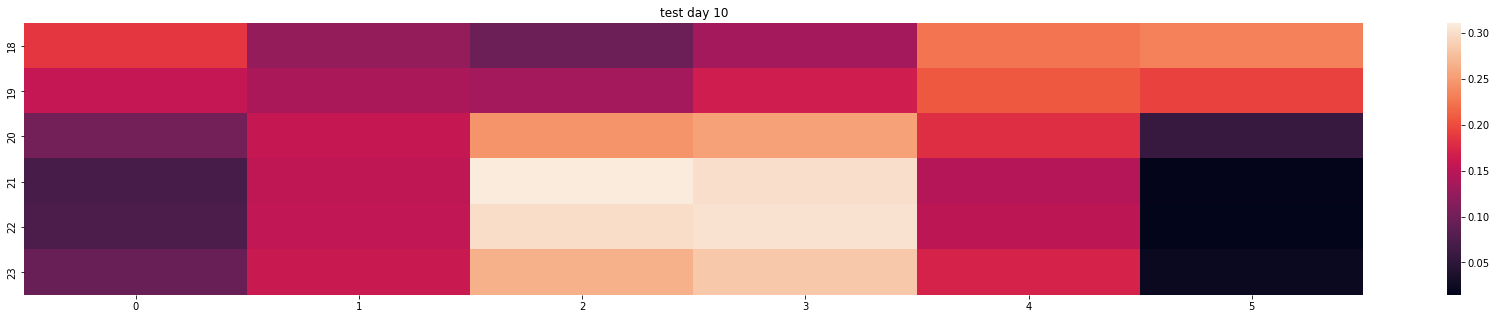

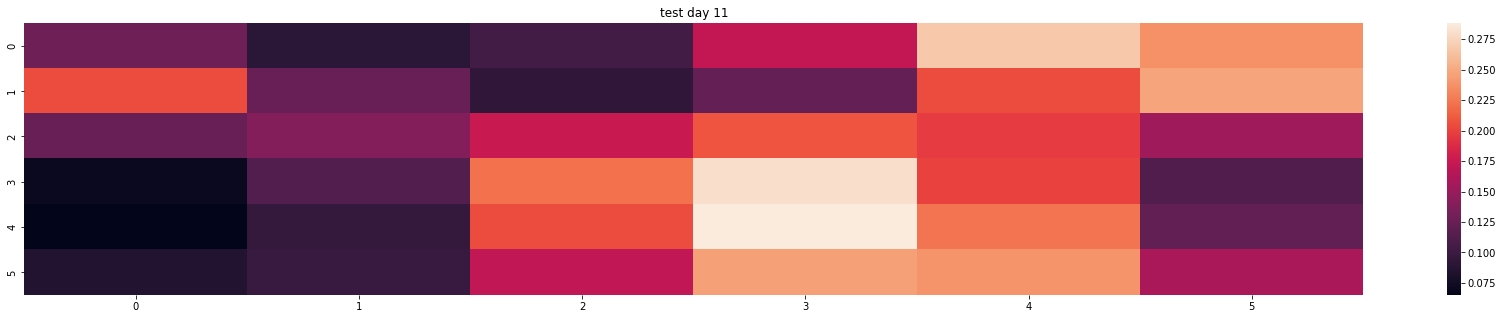

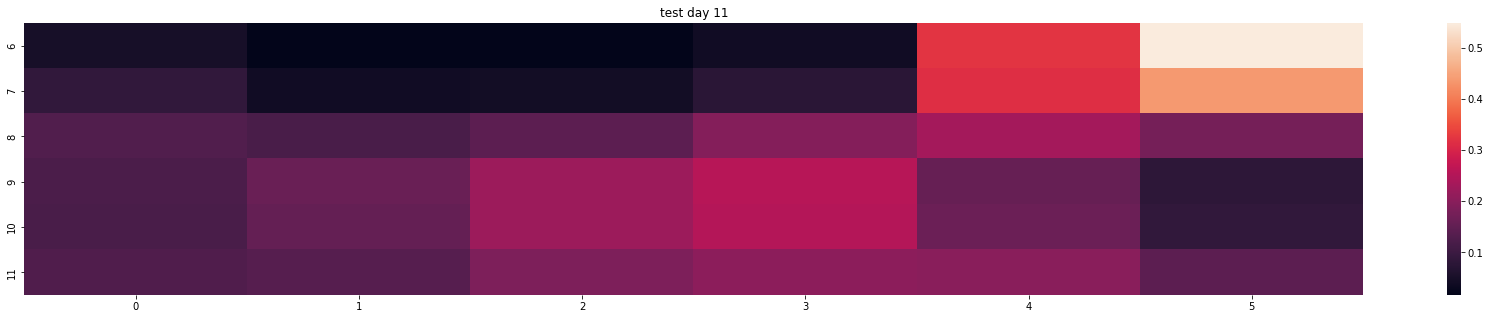

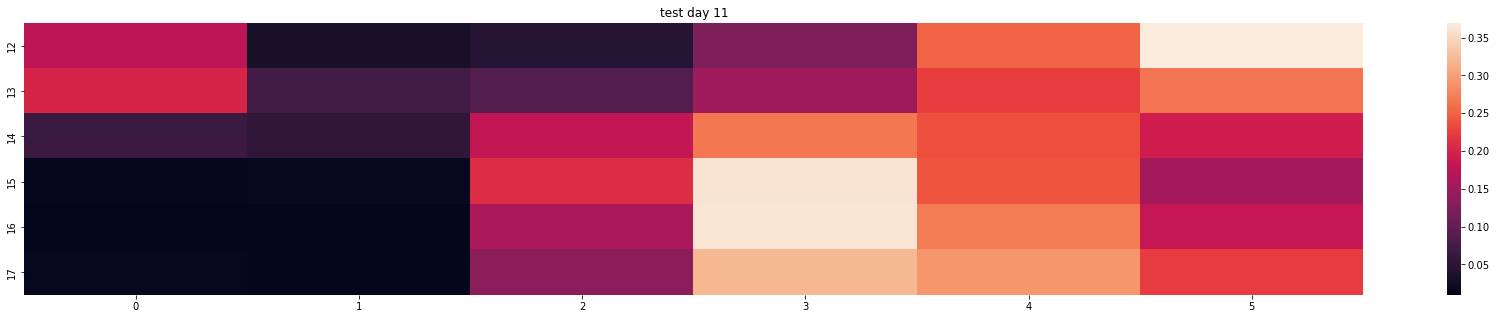

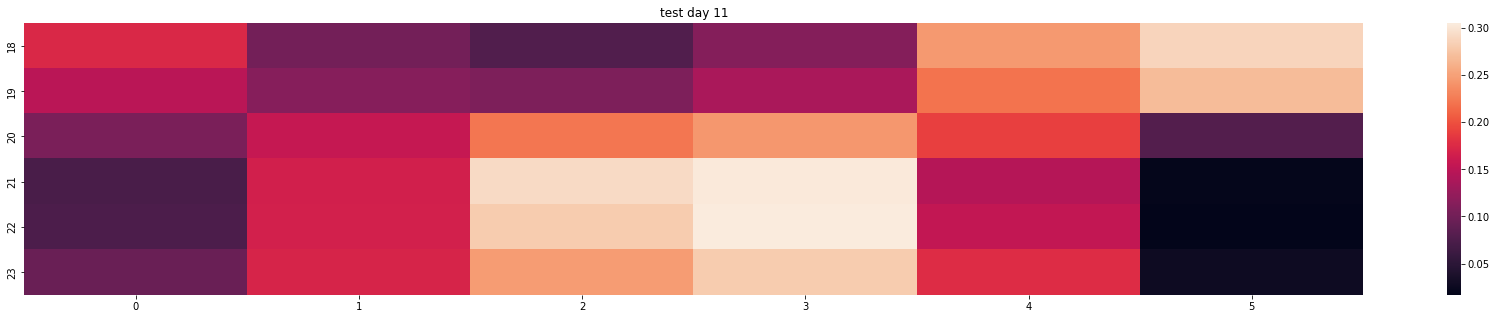

In [48]:
# test set 태양열 발전량 예측에 대한 attention energy 시각화
attention = result_test[2]

for i, att in enumerate(attention):
    plt.figure(figsize=(30,5))
    # sns.heatmap(att, xticklabels=[i%24 for i in range(167)])
    sns.heatmap(att, yticklabels=[time+6*((i)%4) for time in range(6)])
    plt.title(f"test day {i//4 + 1}")
    plt.show()